In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
pip install scikit-plot

In [ ]:
import math
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import to_categorical


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/fer2013/fer2013/fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [ ]:
emotion_label_to_text = {0:'angery', 1:'disgust', 2:'fear', 3:'happy', 4: 'sad', 5: 'surprise', 6: 'neutral'}

In [ ]:
df.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

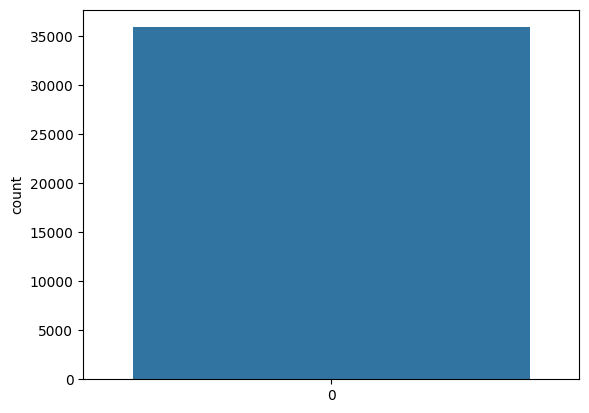

In [ ]:
sns.countplot(df.emotion)
pyplot.show()

In [ ]:
math.sqrt(len(df.pixels[0].split(' ')))

48.0

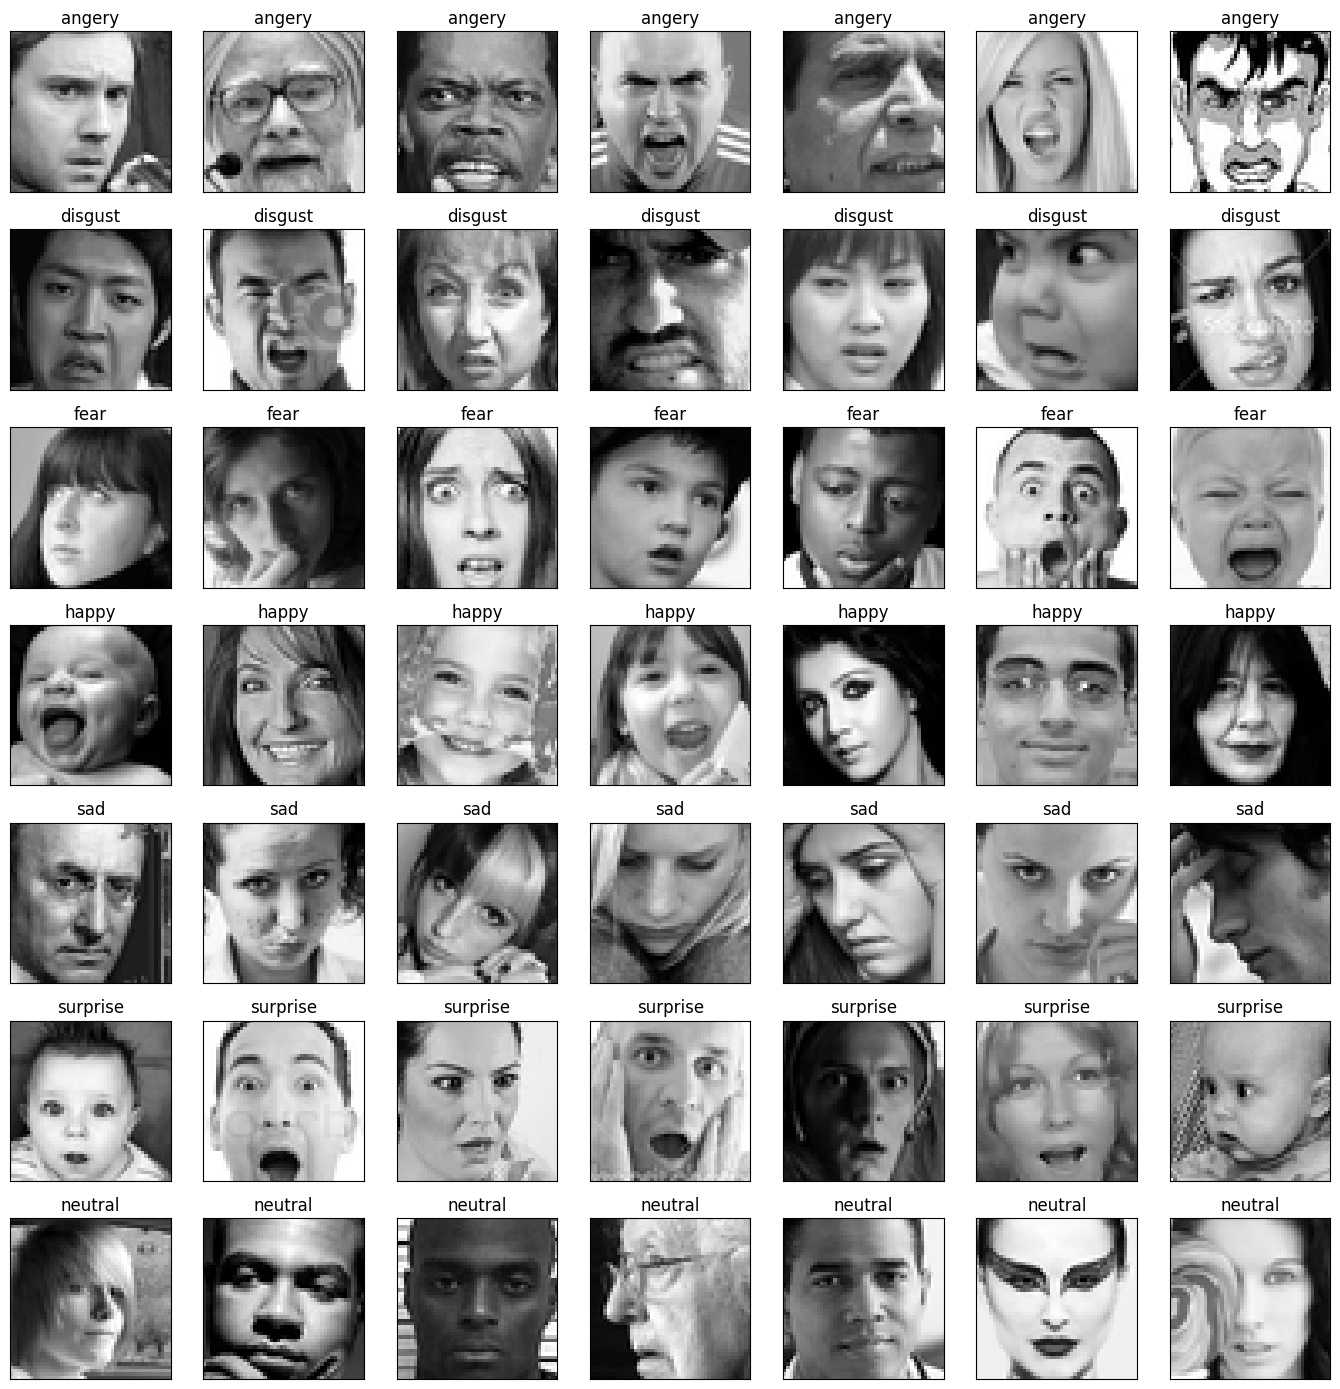

In [ ]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()


In [ ]:
INTERESTED_LABELS = [3, 4, 6]

In [ ]:
df = df[df.emotion.isin(INTERESTED_LABELS)]
df.shape

(21264, 3)

In [ ]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [ ]:
img_array.shape

(21264, 48, 48, 1)

In [ ]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = to_categorical(img_labels)
img_labels.shape

(21264, 3)

In [ ]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{3: 0, 4: 1, 6: 2}


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((19137, 48, 48, 1), (2127, 48, 48, 1), (19137, 3), (2127, 3))

In [ ]:
del df
del img_array
del img_labels

In [ ]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [ ]:
X_train = X_train / 255.
X_valid = X_valid / 255.

In [ ]:
def build_net(optim):
    """
    This is a Deep Convolutional Neural Network (DCNN). For generalization purpose I used dropouts in regular intervals.
    I used `ELU` as the activation because it avoids dying relu problem but also performed well as compared to LeakyRelu
    atleast in this case. `he_normal` kernel initializer is used as it suits ELU. BatchNormalization is also used for better
    results.
    """
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))

    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))

    net.add(Dropout(0.6, name='dropout_4'))

    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )

    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )

    net.summary()

    return net

In [ ]:
"""
I used two callbacks one is `early stopping` for avoiding overfitting training data
and other `ReduceLROnPlateau` for learning rate.
"""

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [ ]:
batch_size = 32 #batch size of 32 performs the best.
epochs = 50
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]

# I tried both `Nadam` and `Adam`, the difference in results is not different but I finally went with Nadam as it is more popular.
model = build_net(optims[1])



Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        1664      
                                                                 
 batchnorm_1 (BatchNormaliz  (None, 48, 48, 64)        256       
 ation)                                                          
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliz  (None, 48, 48, 64)        256       
 ation)                                                          
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)        0      

In [ ]:
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)
model.save('/content/drive/My Drive/FERModel/FERModel.h5')


Epoch 1/50
598/598 [==============================] - 32s 38ms/step - loss: 1.3236 - accuracy: 0.3948 - val_loss: 1.0472 - val_accuracy: 0.4626 - lr: 0.0010
Epoch 2/50
598/598 [==============================] - 21s 36ms/step - loss: 1.0297 - accuracy: 0.4791 - val_loss: 0.8801 - val_accuracy: 0.5844 - lr: 0.0010
Epoch 3/50
598/598 [==============================] - 22s 36ms/step - loss: 0.9034 - accuracy: 0.5604 - val_loss: 0.7664 - val_accuracy: 0.6408 - lr: 0.0010
Epoch 4/50
598/598 [==============================] - 20s 33ms/step - loss: 0.8014 - accuracy: 0.6171 - val_loss: 0.7390 - val_accuracy: 0.6417 - lr: 0.0010
Epoch 5/50
598/598 [==============================] - 20s 33ms/step - loss: 0.7477 - accuracy: 0.6507 - val_loss: 0.6915 - val_accuracy: 0.6841 - lr: 0.0010
Epoch 6/50
598/598 [==============================] - 22s 36ms/step - loss: 0.7090 - accuracy: 0.6814 - val_loss: 0.6559 - val_accuracy: 0.7052 - lr: 0.0010
Epoch 7/50
598/598 [==============================] - 22s 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
loaded_model = tf.keras.models.load_model('/content/drive/My Drive/FERModel/FERModel.h5')

NameError: ignored

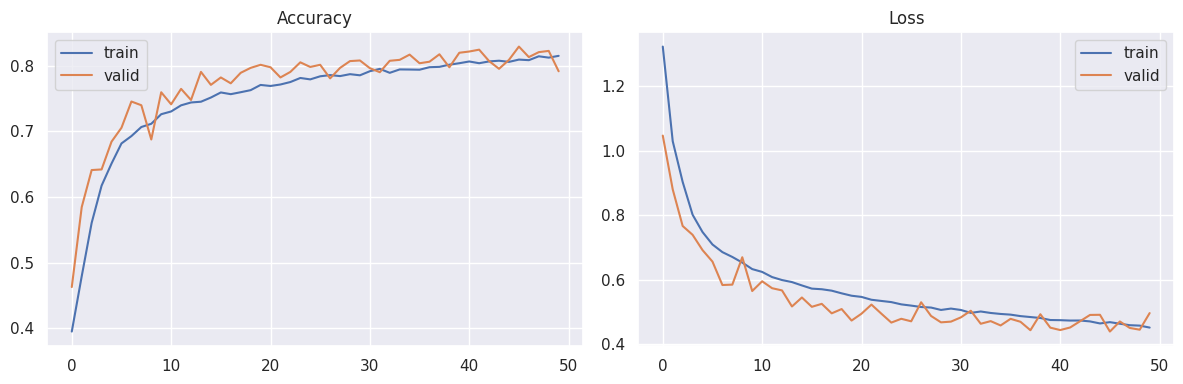

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot Accuracy
ax = axes[0]
ax.plot(history.epoch, history.history['accuracy'], label='train')
ax.plot(history.epoch, history.history['val_accuracy'], label='valid')
ax.set_title('Accuracy')
ax.legend()

# Plot Loss
ax = axes[1]
ax.plot(history.epoch, history.history['loss'], label='train')
ax.plot(history.epoch, history.history['val_loss'], label='valid')
ax.set_title('Loss')
ax.legend()

plt.tight_layout()
plt.savefig('epoch_history_dcnn.png')
plt.show()


In [ ]:
import cv2
import tensorflow as tf

# Load the saved model
model = tf.keras.models.load_model('/content/drive/My Drive/FERModel/FERModel.h5')
import cv2
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
cap = cv2.VideoCapture(0)  # Assuming default webcam
while True:
    ret, frame = cap.read()
    # Process the frame (next steps)
 # Load face detection model
faces = face_cascade.detectMultiScale(frame, 1.3, 5)

emotion_prediction = model.predict(features)
for (x, y, w, h) in faces:
    cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
    cv2.putText(frame, predicted_emotion, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
cv2.imshow('Facial Expression Recognition', frame)
if cv2.waitKey(1) == ord('q'):
  break
cap.release()
cv2.destroyAllWindows()


KeyboardInterrupt: ignored

In [ ]:
import tensorflow as tf

# Load the saved model
model = tf.keras.models.load_model('/content/drive/My Drive/FERModel/FERModel.h5')
import cv2
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
face_haar_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()

    if not ret:
        break

    height, width, _ = frame.shape
    gray_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = face_haar_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    try:
        for (x, y, w, h) in faces:
            # Draw a rectangle around the detected face
            cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)

            # Extract and preprocess the face region for emotion prediction
            roi_gray = gray_image[y:y + h, x:x + w]
            roi_gray = cv2.resize(roi_gray, (48, 48))
            image_pixels = img_to_array(roi_gray)
            image_pixels = np.expand_dims(image_pixels, axis=0)
            image_pixels /= 255.0

            # Make predictions using the loaded model
            predictions = model.predict(image_pixels)
            max_index = np.argmax(predictions[0])
            emotion_detection = ('angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise')
            emotion_prediction = emotion_detection[max_index]

            # Display emotion prediction and confidence
            cv2.putText(frame, f"Emotion: {emotion_prediction}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
            cv2.putText(frame, f"Confidence: {np.max(predictions[0]) * 100:.2f}%", (x, y + h + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

    except Exception as e:
        pass

    cv2.imshow('Emotion Detection', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [ ]:
!pip install --upgrade opencv-python


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 9.0 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.8.0.76
    Uninstalling opencv-python-4.8.0.76:
      Successfully uninstalled opencv-python-4.8.0.76


In [ ]:
import cv2
from google.colab.patches import cv2_imshow

# Connect to the webcam
cap = cv2.VideoCapture(0)

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Check if the frame is valid
    if not ret:
        print("Error: Failed to capture frame")
        break

    # Display the frame
    cv2_imshow(frame)

    # Break the loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close all windows
cap.release()
cv2.destroyAllWindows()


Error: Failed to capture frame


In [ ]:
mapper = {
    0: 'anger',
    1: 'disgust',
    2: 'fear',
    3: 'happiness',
    4: 'sadness',
    5: 'surprise',
    6: 'neutral'
}

1/1 [==============================] - 0s 42ms/step


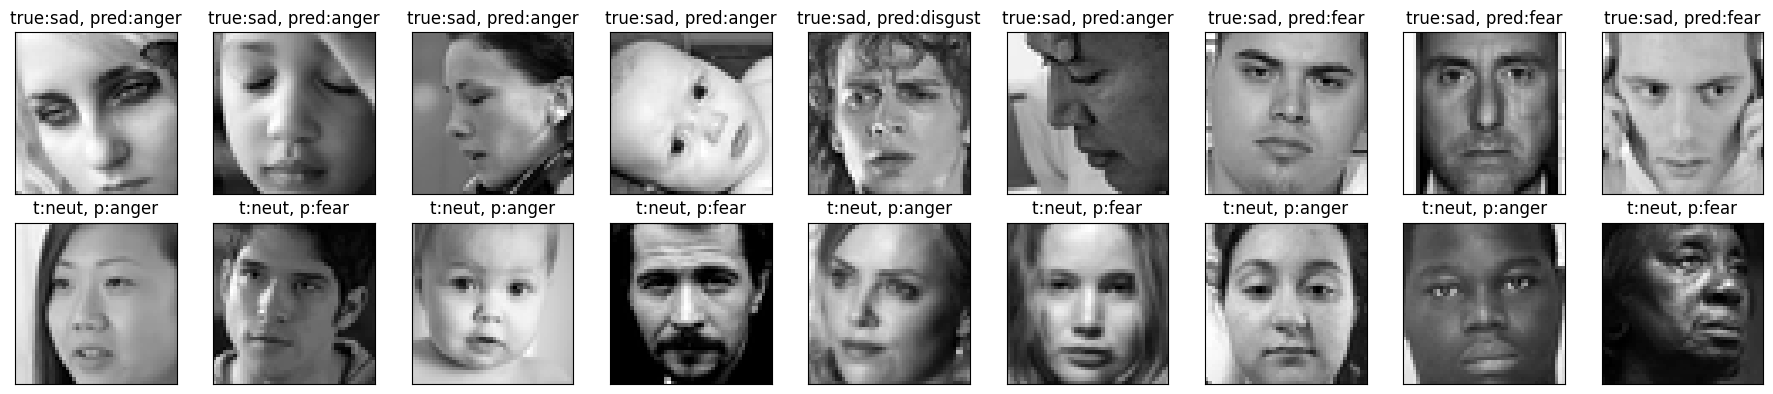

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

np.random.seed(2)

# Load your model
model = tf.keras.models.load_model('/content/drive/My Drive/FERModel/FERModel.h5')

random_sad_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 2]==1)[0], size=9)

fig = plt.figure(1, (18, 4))

for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
    ax = plt.subplot(2, 9, i+1)
    sample_img = X_valid[sadidx,:,:,0]
    ax.imshow(sample_img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

    ax.set_title(f"true:sad, pred:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,1))[0])]}")

    ax = plt.subplot(2, 9, i+10)
    sample_img = X_valid[neuidx,:,:,0]
    ax.imshow(sample_img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

    ax.set_title(f"t:neut, p:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,1))[0])]}")

plt.tight_layout()
plt.show()
